# Task per job analysis

##Mean and Variance Analysis

In [1]:
#                                           *****HELPER FUNCTIONS*****

#cambiare [h] in [us]
#library to draw the graph
import matplotlib.pyplot as plt
#library to find
import glob
#math library
import math
#global variables used to create the new RDDs
#compute different probabilities
def probability(googleRDD):
    #to compute probabilities,uses the number of tasks scheduled
    scheduledTasks=googleRDD.filter(lambda x:x[2]==1)
    total=scheduledTasks.count()
    print "number of scheduled tasks:"+repr(total)
    #count the number of rescheduled events
    numTasksFailed=(googleRDD.filter(lambda x:x[2]==3).count())
    print "Failure probability:"+repr(float(numTasksFailed)/total)
    #compute the number of evicted tasks
    numTaskEvicted=(googleRDD.filter(lambda x:x[2]==2).count())
    print "Evict probability:"+repr(float(numTaskEvicted)/total)
    #number of killed tasks
    numTaskKilled=(googleRDD.filter(lambda x:x[2]==5).count())
    print "Kill probability:"+repr(float(numTaskKilled)/total)
    #number of ended tasks
    numTaskFinished=(googleRDD.filter(lambda x:x[2]==4).count())
    print "Finish probability:"+repr(float(numTaskFinished)/total)
#draw an histogram of the created tasks during time. As input I pass
#the path of the traces, the start and end time [s] (=window)
def tasksOverTime(path,startTime,endTime,event_type):
    intervals=math.ceil((endTime-startTime)/3600)
    #converts to microseconds
    startTimeMs=startTime*1000000
    endTimeMs=endTime*1000000
    #this contains all the trace in the format (timestamp [micros],jobID,event_type)
    googleRDD=(sc.textFile(path)
          .map(lambda x:x.split(','))
           #map every tuple in: (timestamp [micros],jobID,event_type)
          .map(lambda x:(int(x[0]),int(x[2]),int(x[5])))
          #.filter(lambda x:x[0]>=startTimeMs and x[0]<=endTimeMs)
          .filter(lambda x:x[2]==event_type))
    drawHistogram(googleRDD,intervals)
#take as input an RDD of type: [(timestamp[ms],jobID,event_type)]
def drawHistogram(dataRDD,intervals):
    #job count (count how many tasks are generated for each job)
    values=dataRDD.map(lambda x:math.floor(x[0]/3600000000)).collect()
    fig = plt.figure(figsize=(15,4))
    plt.hist(values, intervals, log=False)
    plt.xlabel('Elapsed time[h]')
    plt.ylabel('Created tasks')
    pass
#computes the mean of a set of values. Takes as input a list of type ((tsStart,tsEnd),param,param)
def resultMean(result):
    return sum(n for n in result)/len(result)        
#save the result of the job statistics in a text File
def saveJobResultCsv(result,granularity):
    #save it as filename-[init_hour]-[granularity].txt
    f=open("data/analysisResults/jobs/"+repr(result[0][0][0]/3600000000)+"-"+repr(granularity)+".csv","w")
    for r in result:
        f.write("%d,%d,%f,%f\n" % (r[0][0],r[0][1],r[1],r[2]))
    f.close()
def saveMachineResultCsv(result,machineID,event,granularity):
    f=open("data/analysisResults/machines/"+repr(result[0][0][0]/3600000000)+"-"+repr(machineID)+"event:"+repr(event)+"-"+repr(granularity)+".csv","w")
    for r in result:
        f.write("%d,%d,%f\n" % (r[0][0],r[0][1],r[1]))
    f.close()
#reads a file from the path passed as parameter
def readJobFile(filename,param):
    result=[]
    #parse the output file
    f=open(filename,'r')
    i=0
    for line in f:
        l=line.split(',')
        result.append(((int(l[0]),int(l[1])),float(l[2]),float(l[3].split('\\')[0])))
        i+=1
    draw(1,result)
    drawClusters(1,result,i)
    draw(2,result)
    drawClusters(2,result,i)
#draw the graph given the list of results computed before. pass 1 to draw the mean,2 to draw the variance
def draw(i,result):
    #take the end of the interval 
    xAxis=[n[0][1] for n in result]
    if(i==1):
        yAxis=[n[i] for n in result]
    elif(i==2):
        yAxis=[math.sqrt(n[i]) for n in result]
    if(i==1):
        label='mean #tasks created per job'
    elif(i==2):
        label='dev standard #tasks created per job'
    fig = plt.figure()
    plt.grid()
    plt.plot(xAxis, yAxis)
    result2=[]
    for r in result:
        result2.append(((r[0][0],r[0][1]),r[1],r[2]))
    plt.axhline(resultMean(yAxis),color='k')
    plt.xlabel('Time[us]')
    plt.ylabel(label)
    pass
#draw the different clusters; pass 1 for the mean, 2 for the dev standard
def drawClusters(i,result,numberOfPoints):
    MAX=numberOfPoints
    THRESHOLD=int(MAX-0.15*MAX)
    result2=[]
    if(i==1):
        xAxis=[n[0][1] for n in result[:THRESHOLD]]
        yAxis=[n[i] for n in result[:THRESHOLD]]
        xAxis2=[n[0][1] for n in result[THRESHOLD:MAX]]
        yAxis2=[n[i] for n in result[THRESHOLD:MAX]]
    elif(i==2):
        xAxis=[n[0][1] for n in result[:THRESHOLD]]
        yAxis=[math.sqrt(n[i]) for n in result[:THRESHOLD]]
        xAxis2=[n[0][1] for n in result[THRESHOLD:MAX]]
        yAxis2=[math.sqrt(n[i]) for n in result[THRESHOLD:MAX]]
    if(i==1):
        label='mean tasks created per job'
    else:
        label='dev standard tasks created per job'
    fig = plt.figure()
    plt.grid()
    plt.plot(xAxis,yAxis)
    plt.axhline(resultMean(yAxis),color='k')
    plt.xlabel('Time[us]')
    plt.ylabel(label)
    fig2 = plt.figure()
    plt.grid()
    plt.plot(xAxis2,yAxis2)
    plt.axhline(resultMean(yAxis2),color='k')
    plt.xlabel('Time[us]')
    plt.ylabel(label)
    pass
#read the machine file, passing the filename and the event (used to print a graph)
def readMachineFile(filename,event):
    result=[]
    #parse the output file
    f=open(filename,'r')
    i=0
    for line in f:
        l=line.split(',')
        result.append(((int(l[0]),int(l[1])),float(l[2].split('\\')[0])))
    drawMachine(event,result)
#draw the graph given the list of results computed before. pass 1 to draw the mean,2 to draw the variance
def drawMachine(i,result):
    fig = plt.figure()
    plt.grid()
    xAxis=[n[0][1] for n in result]
    yAxis=[n[1] for n in result]
    if(i==1):
        label='scheduled tasks'
    elif(i==2):
        label='evicted tasks'
    elif(i==3):
        label='failed tasks'
    elif(i==4):
        label='completed tasks'
    plt.plot(xAxis, yAxis)
    plt.axhline(resultMean([n[1] for n in result]),color='k')
    plt.xlabel('Time[us]')
    plt.ylabel(label)
    if(i==1):
        plt.ylim((0,100))
    elif(i==4):
        plt.ylim(0,10)
    pass
#finds the most used machines in the trace passed as input=machines to which more tasks are scheduled
def findMostUsedMachines(path):
    machineRDD=(sc.textFile(path)
                .map(lambda x:x.split(','))
                .filter(lambda x:x[4]!='')
                .map(lambda x:(int(x[4]),int(x[5])))
                .filter(lambda x:x[1]==1)
                .map(lambda x:(x[0],1))
                .reduceByKey(lambda x,y:x+y))
    print "First 10 most used machines"
    print machineRDD.takeOrdered(10,lambda k:-k[1])
#counts the number of distinct machines in the specified window
def listMachines(startTime,endTime):
    startTimeMs=startTime*1000000
    endTimeMs=endTime*1000000
    machinesRDD=(sc.textFile('file:///home/vagrant/data/googleTraces/*.csv.gz')
                 .map(lambda x:x.split(','))
               .map(lambda x:(int(x[0]),x[4]))
               .filter(lambda x:x[0]>=startTimeMs and x[0]<=endTimeMs)
               .map(lambda x:x[1])
               .distinct())
    result=machinesRDD.collect()     
    result.pop(0)
    m=[]
    for r in result:
        m.append(int(r))
    return m
def meanTaskPerJobDict(jobDict):
    if(len(jobDict)==0):
        return 0
    values=jobDict.values()
    s=sum(values)
    return float(s/len(jobDict))
def varianceTaskPerJobDict(jobDict,mean):
    if(len(jobDict)==0):
        return 0
    squareSum=0
    for v in jobDict.values():
        squareSum+=pow(v-mean,2)
    return float(squareSum/len(jobDict))    

End of the parsing.I'm Starting the analysis..


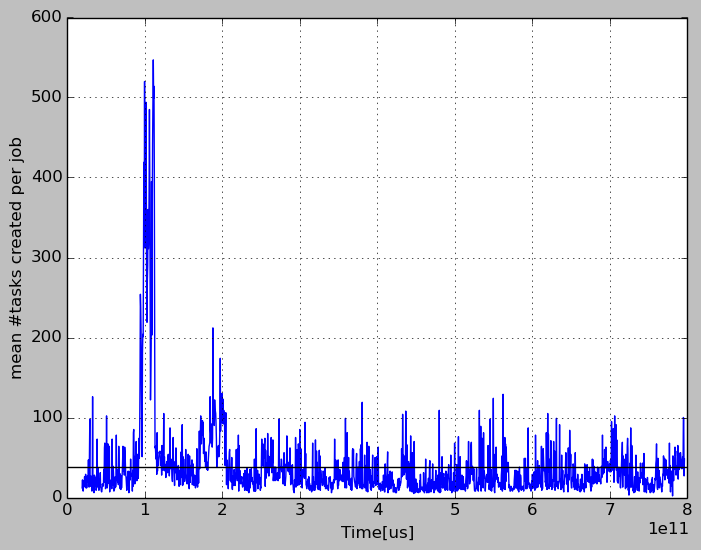

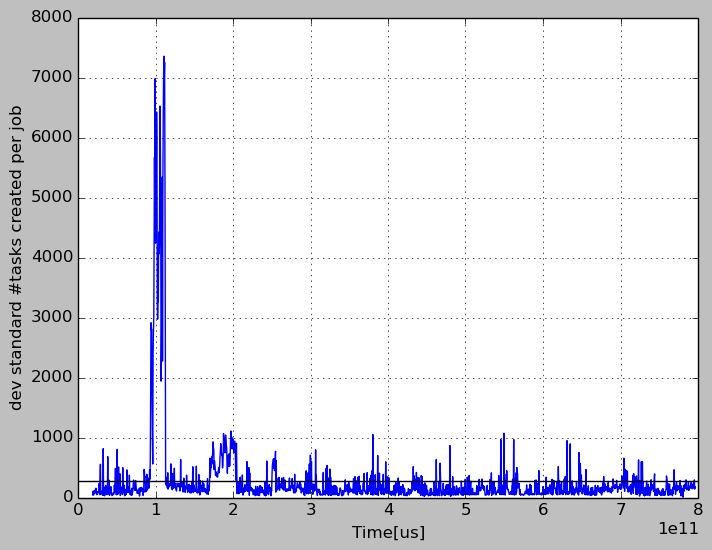

In [3]:
def countJobs(startTimeMs,endTimeMs,granularityMs,records,jobDict,result):
    i=0
    #split by granularity and for each interval finds mean and variance
    while(startTimeMs<endTimeMs):
        #compute the sub-window
        e=startTimeMs+granularityMs
        #until we are in the interval
        while(records[i][0]<=e and i<(len(records)-1)):
            if(records[i][1] in jobDict):
                jobDict[records[i][1]]+=1
            else:
                jobDict[records[i][1]]=1
            i+=1
        mean=meanTaskPerJobDict(jobDict)
        variance=varianceTaskPerJobDict(jobDict,mean)
        #appends the result to the list
        result.append(((startTimeMs,e),mean,variance))
        jobDict={}
        #slide the window
        startTimeMs=e
    saveJobResultCsv(result,granularityMs/1000000)
    draw(1,result)
    draw(2,result)
#main function:takes as input the path of the file,window [s] and the granularity[s] ()
#returns a list of type ((startTimeG,endTimeG),mean,variance)
def computeJobData(path,startTime,endTime,granularity,event_type):
    if(startTime>endTime):
        print "Wrong window"
        return
    #converts to microseconds
    startTimeMs=startTime*1000000
    endTimeMs=endTime*1000000
    granularityMs=granularity*1000000
    #this contains all the trace in the format (timestamp [micros],jobID,event_type)
    googleRDD=(sc.textFile(path)
          .map(lambda x:x.split(','))
           #map every tuple in: (timestamp [micros],jobID,event_type)
          .map(lambda x:(int(x[0]),int(x[2]),int(x[5])))
          .filter(lambda x:x[2]==event_type)
          .filter(lambda x:x[0]>=startTimeMs and x[0]<=endTimeMs)
          .map(lambda x:(x[0],x[1])))
    #Now the RDD contains tuples like (timestamp,jobID)
    result=[]
    #all the ordered records: (timestamp,jobID). Very expensive because it has to order everything based on timestamps
    records=googleRDD.takeOrdered(googleRDD.count(),lambda x:x[0])
    print "End of the parsing.I'm Starting the analysis.."
    #init a dictionary
    jobDict={}
    #This should be modified every time depending on what you want to do..(it's not good programming but for now is suitable)
    #inner function to iterates over the list. WIth this function the part of different granularities becomes more manageable
    while(granularityMs>=(3600/8)*1000000):
        countJobs(startTimeMs,endTimeMs,granularityMs,records,jobDict,result)
        granularityMs/=2
        result=[]
#takes all the available traces
computeJobData('file:///home/vagrant/data/googleTraces/*.csv.gz',18600,796200,3600/8,0)

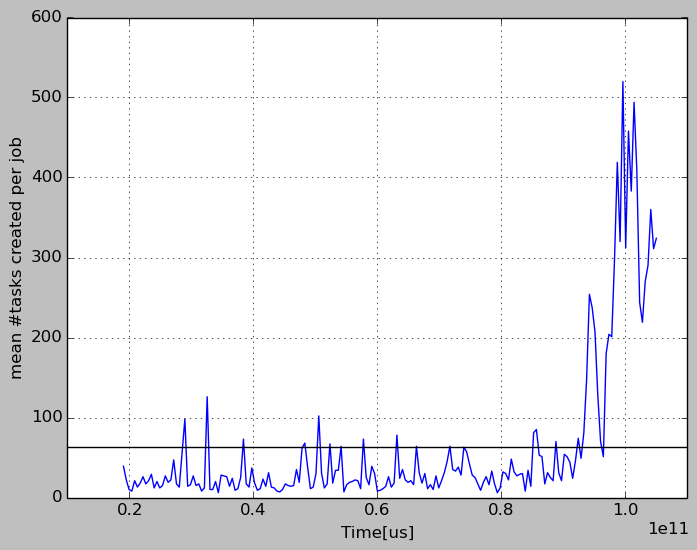

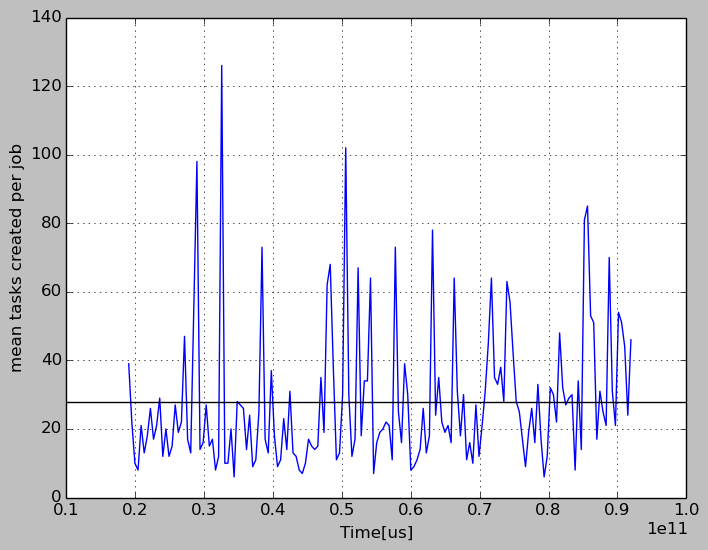

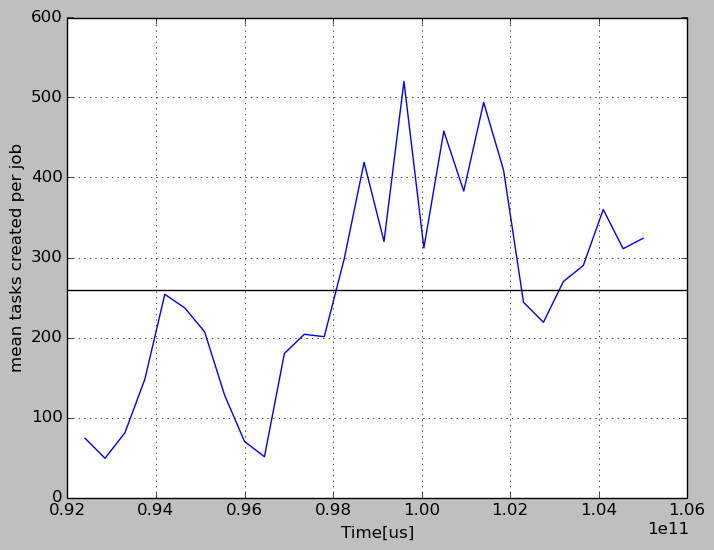

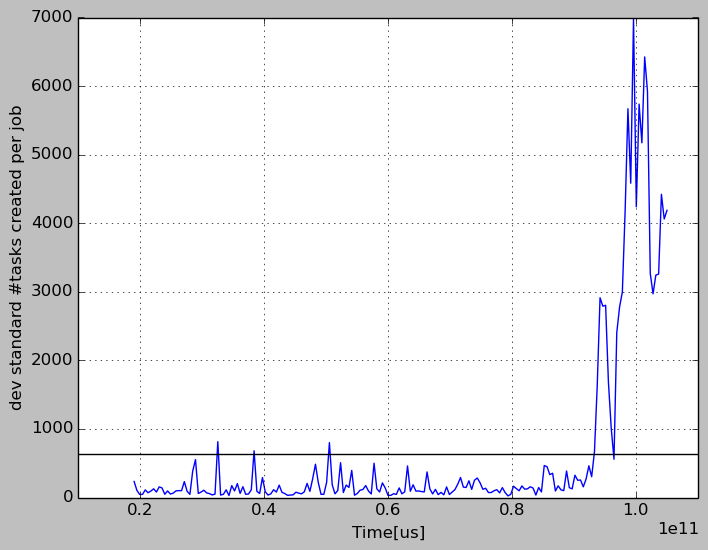

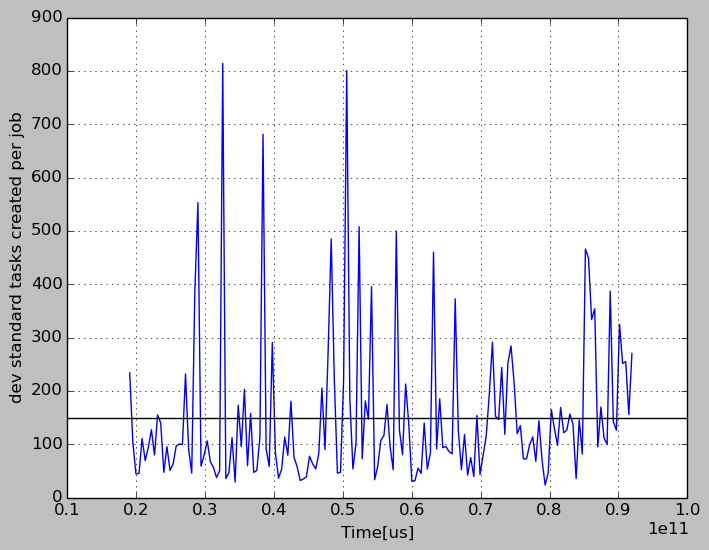

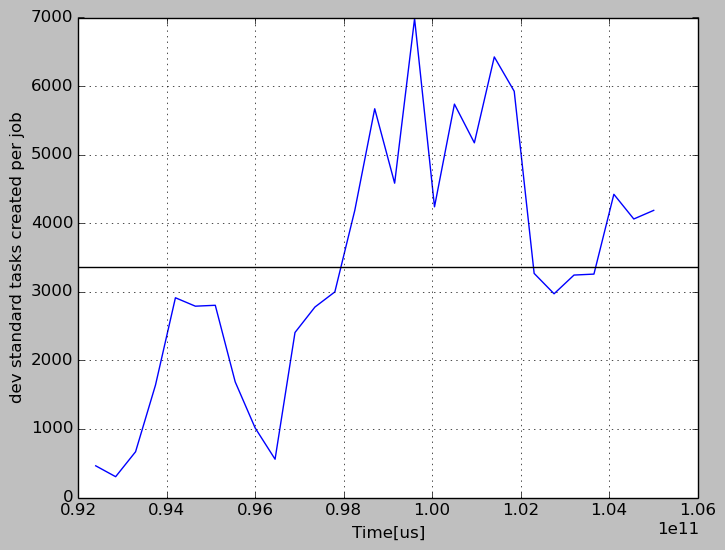

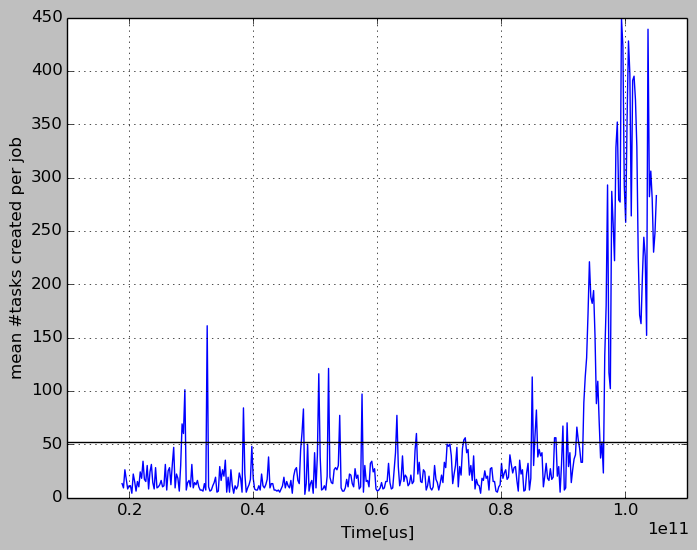

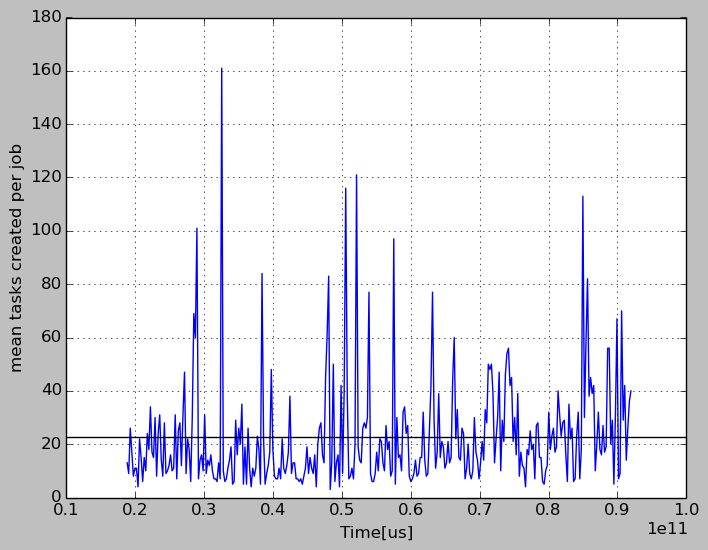

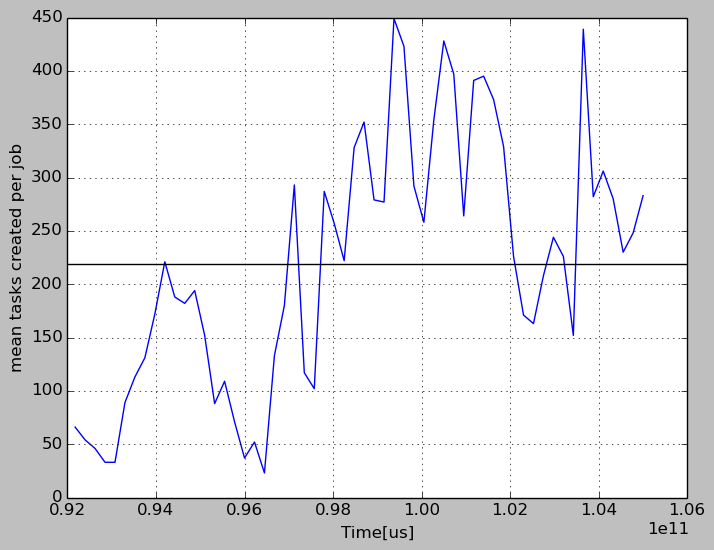

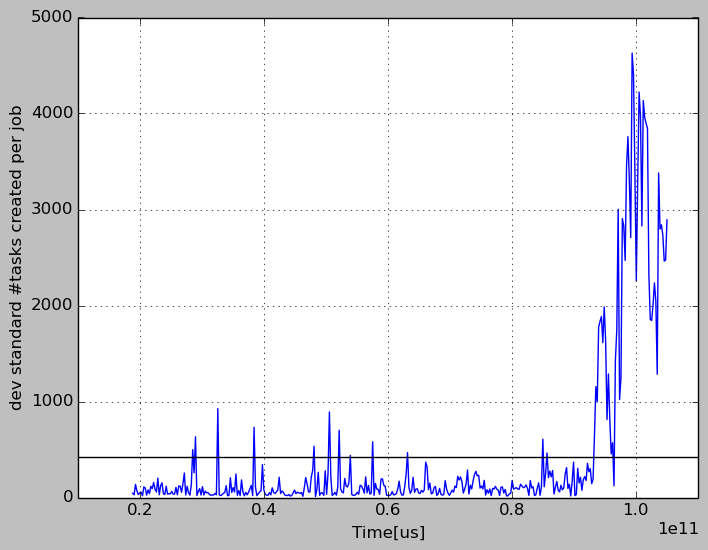

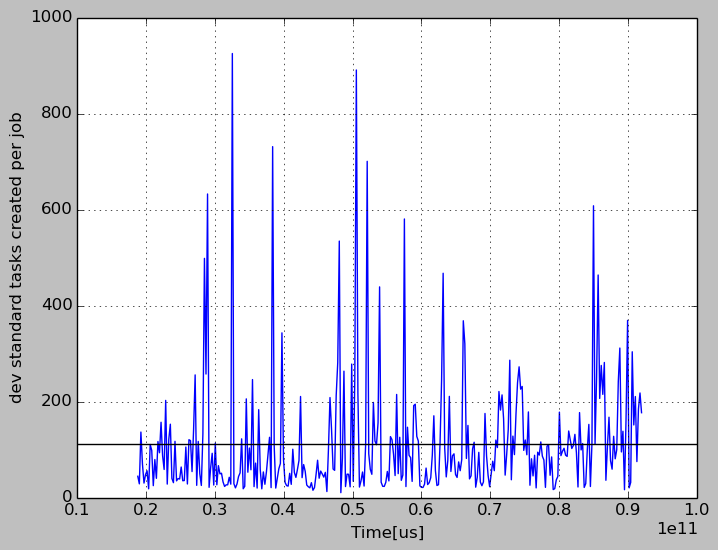

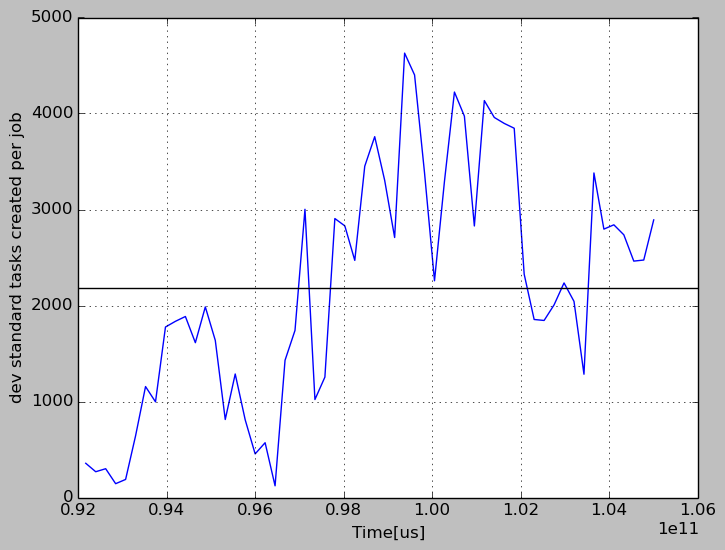

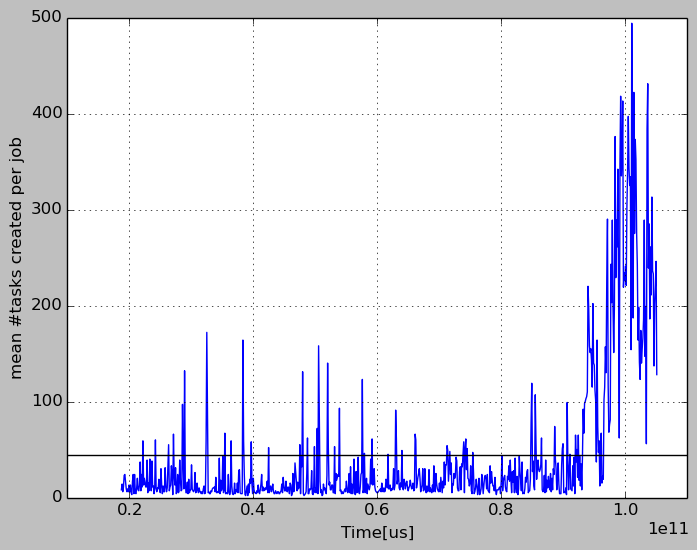

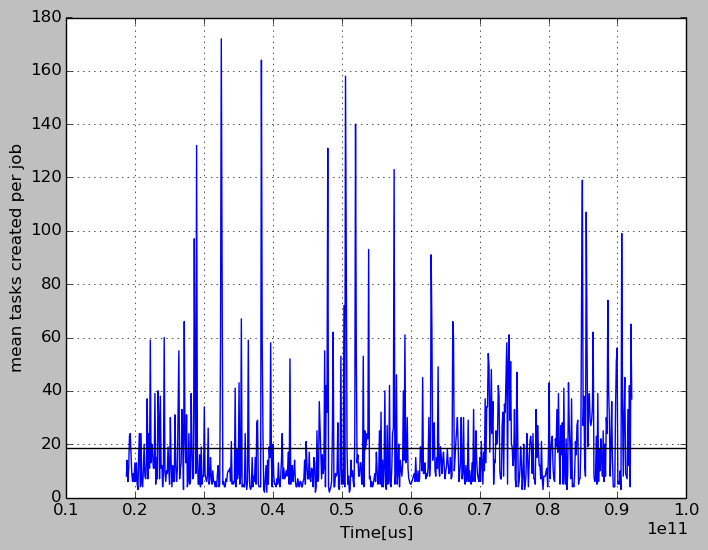

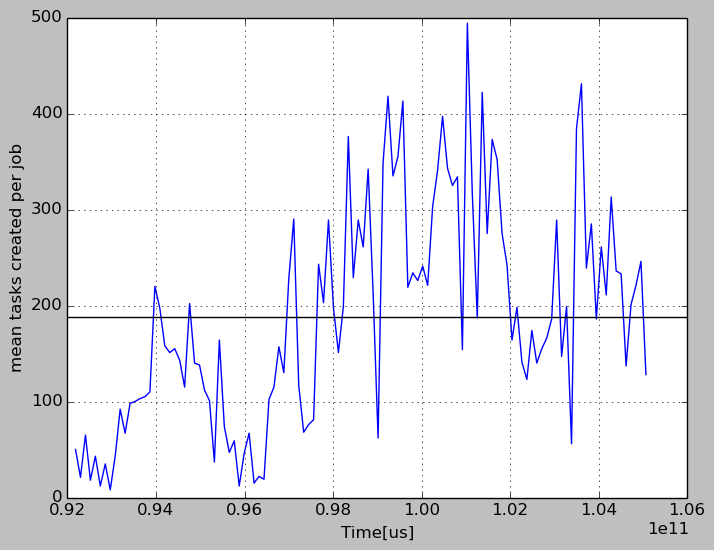

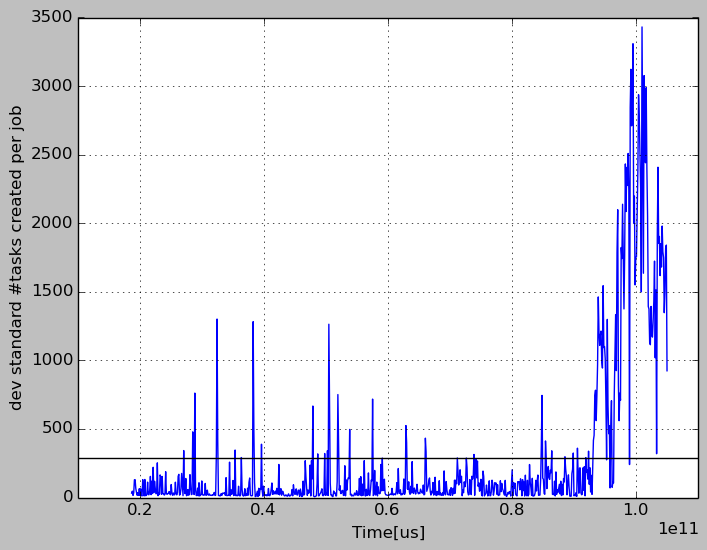

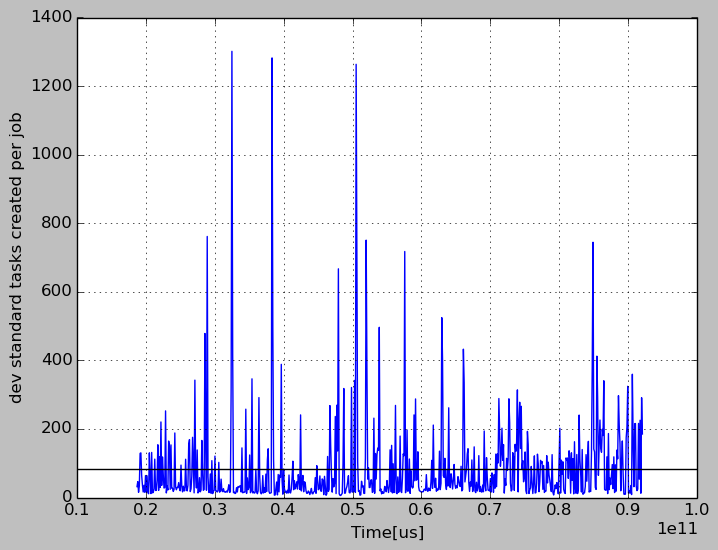

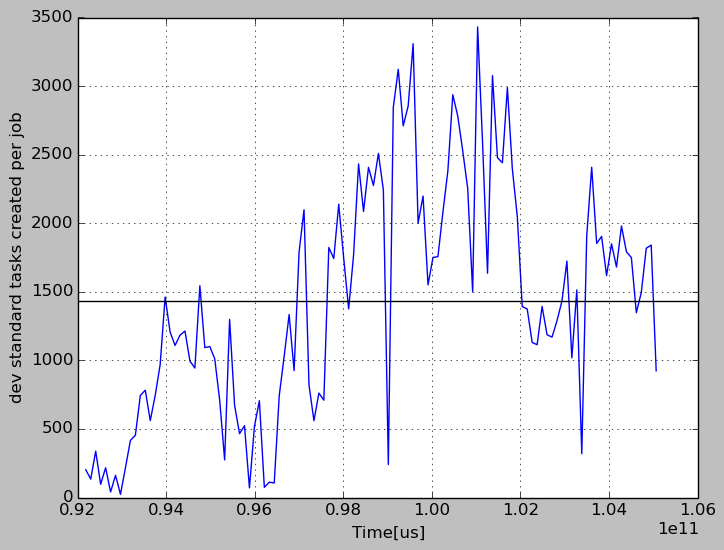

In [4]:
#PER FRANCESCA====> QUA LEGGO TUTTI I FILE,GRAFICI SPEZZATI. nell'ordine sono i grafici con 8,16 e 32 punti per periodo
#(questi dovrebbero bastare). Nota che li stampo in questo modo: grafico totale media, grafico cluster 1 media,grafico 
#cluster 2 media, grafico totale dev standard, grafico cluster 1 dev standard, grafico cluster 2 dev standard.
#io specificherei il fatto che questi grafici si riferiscono al numero di task sottomessi da un job, non schedulati
readJobFile('data/analysisResults/jobs/5L-450L.txt',1)
readJobFile('data/analysisResults/jobs/5L-225.txt',1)
readJobFile('data/analysisResults/jobs/5L-112.txt',1)

##find tasks during time with a certain property

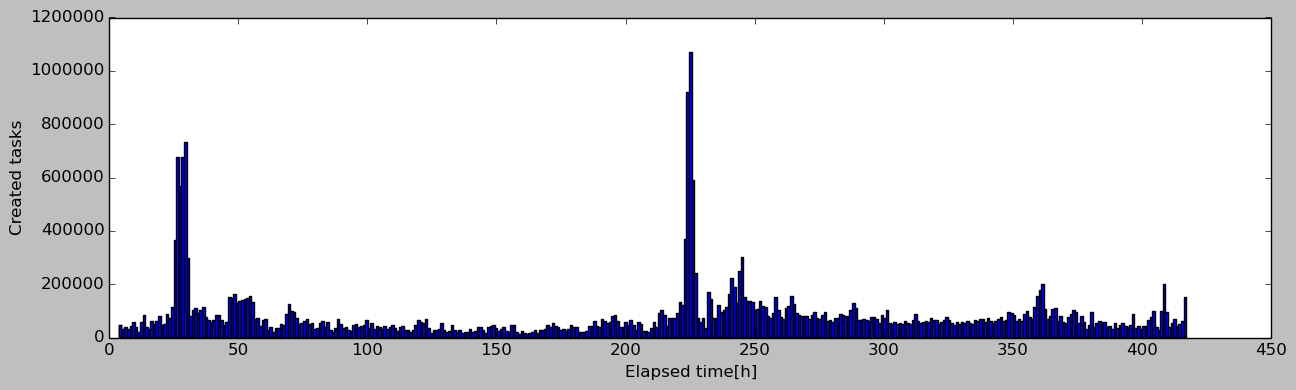

In [2]:
#pay attention: very computational intensive
tasksOverTime('file:///home/vagrant/data/googleTraces/*.csv.gz',18600,1503959,0)

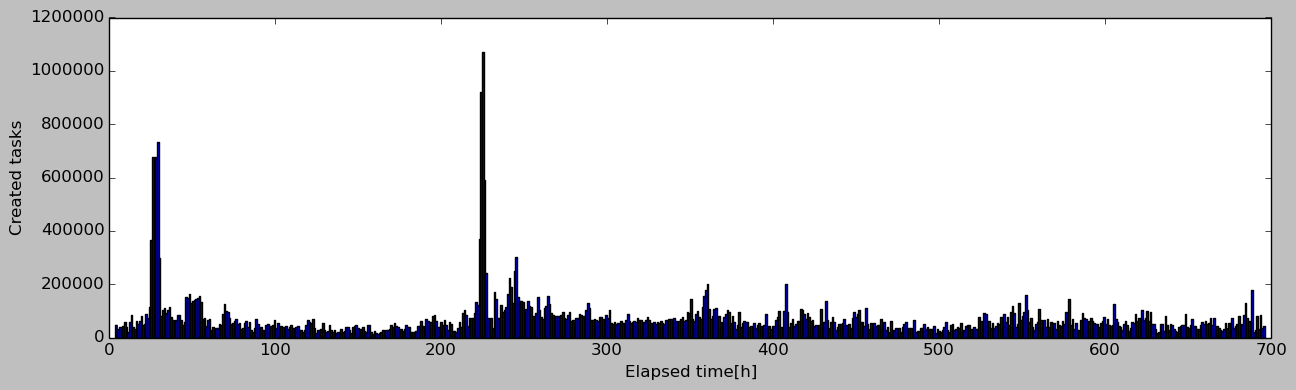

In [2]:
tasksOverTime('file:///home/vagrant/data/googleTraces/*.csv.gz',18600,2506199,0)

## reading all files

89.2502695417
89.2502695417


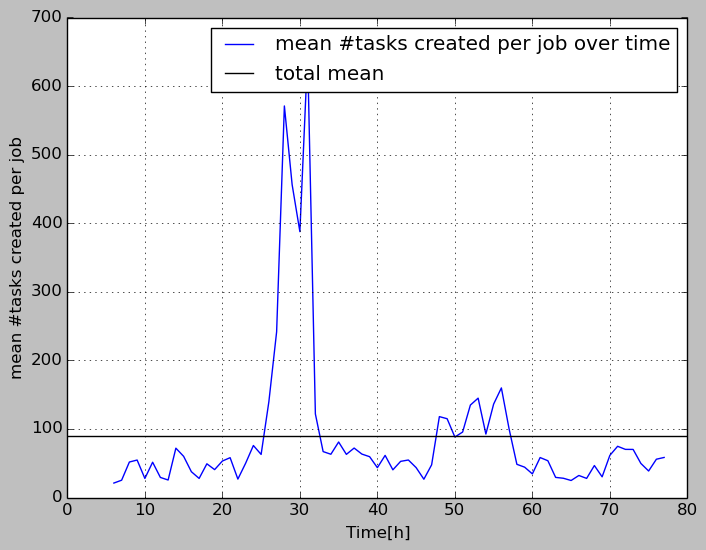

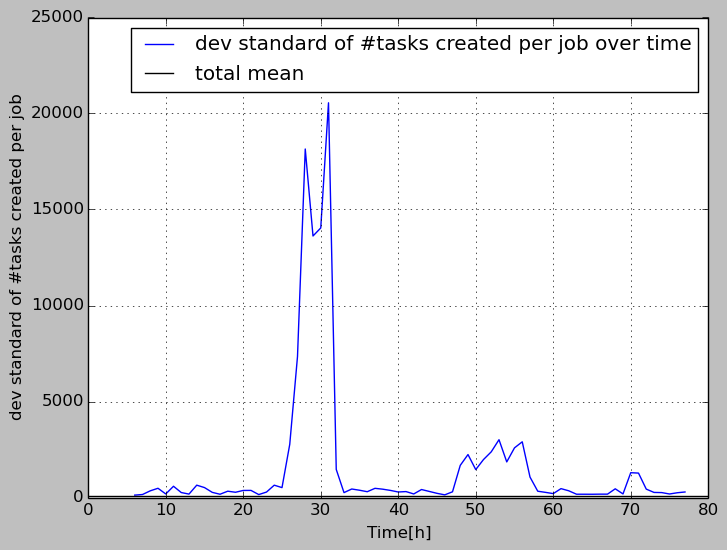

In [26]:
readJobFiles('data/analysisResults/jobs')

#Task Per Machine Analysis

In [ ]:
#TROVO PRIMA LE MACCHINE CHE RICEVONO PIU TASK, POI CALCOLO IL NUMERO DI TASK COMPLETATI DA QUELLE MACCHINE (DATO RILEVANTE,
#IN QUANTO POSSO CALCOLARE IL THROUGHPUT SAPENDO QUANTI TASK COMPLETANO NEL TEMPO).
#SALVO NEI FILE DI TESTO, CHE SEGUONO LA NAMING CONVENTION: [timestampIniziale]-[machineID]-event:[event_type]-Day.txt.
#la naming convention puo essere importante specificarla nel documento.. è cosi complicata perchè facendo tutto in automatico
#devo garantire nomi univoci anche in presenza di stessa macchina,stesso ts ma nell'analisi di un evento differente, altrimenti
#rischio di sovrascrivere il file precedente

In [ ]:
#QUI CI SONO I DATI RIGUARDO LE MACCHINE CHE RICEVONO PIU TASK (QUELLE MACCHINE CHE HANNO RICEVUTO PIU EVENTI DI TIPO 1 
#=TASK SCHEDULED). I DATI RIGURDANO I TASK CHE HANNO COMPLETATO NEL TEMPO (IN QUESTO MODO SI PUO CALCOLARE IL THROUGHPUT)
#IN PRATICA HO CERCATO,PER OGNI MACCHINA CHE RICEVEVA PIU TASK, QUANTI TASKS HA COMPLETATO (EVENTO 4,FINISH) NELLA GIORNATA.
#IL NUMERO E BASSO,NON SO IL PERCHE. DOVREMMO RAGIONARCI.
#QUA SOTTO APPUNTO CI SONO I GRAFICI DEI TASK COMPLETATI NEL TEMPO PER QUALCHE MACCHINA.
#IO PENSO CHE IL BASSO NUMERO DI TASK COMLETATI SIA DOVUTO AL FATTO CHE SIAMO SOLO AL SECONDO GIORNO, E MOLTI TASKS
#SCHEDULATI VENGONO COMPLETATI MAGARI IL TERZO O IL QUARTO GIORNO..
#POI OVVIAMENTE IL NUMERO DI MACCHINE è ELEVATO,QUINDI A UNA MACCHINA VENGONO ASSEGNATI POCHI TASK.
#SE GUARDI NEI .TXT CI SONO ALCUNI FILE CHE CONTENGONO I TASK SCHEDULATI PER OGNI MACCHINA (SONO I FILE CON EVENT:1 DENTRO AL NOME)
#un possibile risultato quindi è che queste macchine (almeno per quanto riguarda il secondo giorno) sono,diciamo
#"sottoutilizzate",completano pochi task.. è strano..

In [13]:
machines=listMachines(18600,105000)

In [15]:
print machines
print "number of machines:"+repr(machines)

[38742360, 4820110436L, 38691507, 82731175, 554347872, 682456, 38643412, 3863393958L, 207925075, 567617, 2596189359L, 368695780, 38690843, 3890625724L, 717323, 4304773033L, 351662743, 155395763, 422087, 38709565, 4820106854L, 317477829, 351634506, 97983610, 7777795, 257511651, 4820028357L, 711415, 3306300923L, 257337175, 257406696, 711354, 46296128, 16915965, 294901601, 4346144621L, 309364176, 602982, 336047565, 30790112, 699830048, 4304784540L, 3668262859L, 257339942, 63625914, 599793, 294771764, 1271465, 6566579, 4802125502L, 5175267028L, 4820075588L, 317484337, 351612258, 3630727628L, 765896, 1343208, 711521, 1319905, 704576235, 273549095, 305387610, 6566592, 1436330764, 4802885672L, 1436350589, 717252, 4874535772L, 317488580, 662206, 854779389, 207802307, 16917219, 3778560217L, 672947713, 38693395, 16917166, 351642820, 449907210, 2568523361L, 97958667, 294922359, 38737478, 765679, 3502512890L, 1094868, 30789406, 294847185, 351620863, 3811742316L, 2796972389L, 284786939, 6567630, 16

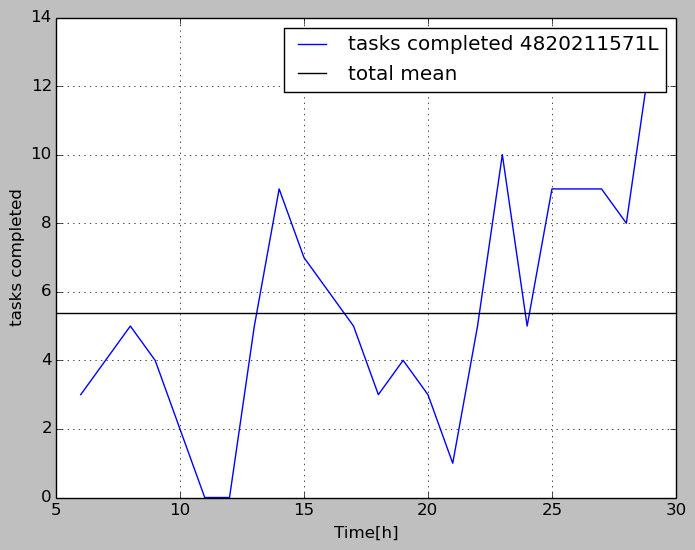

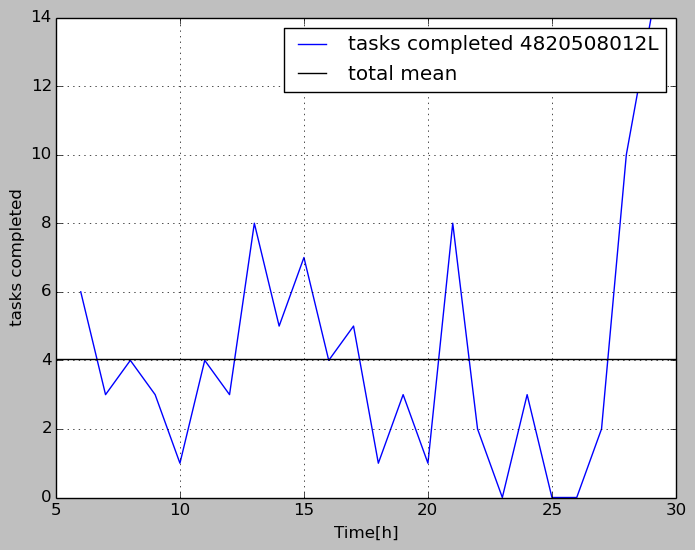

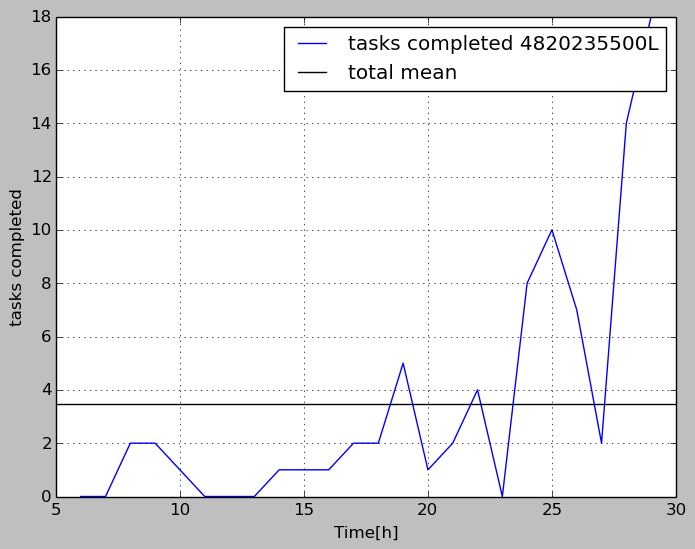

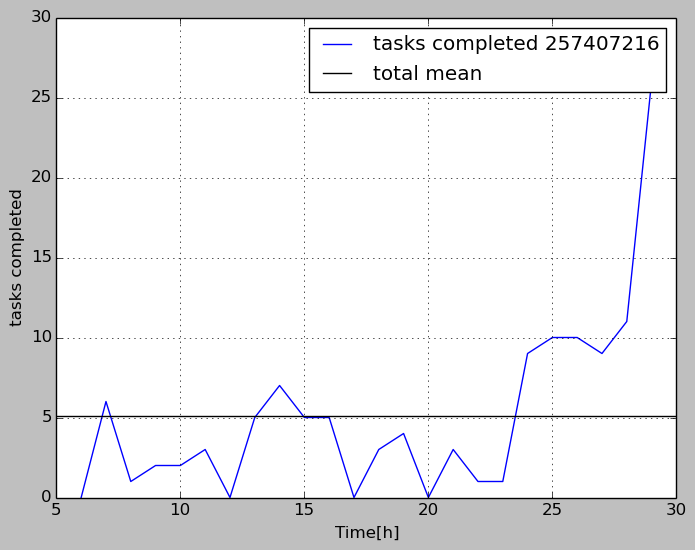

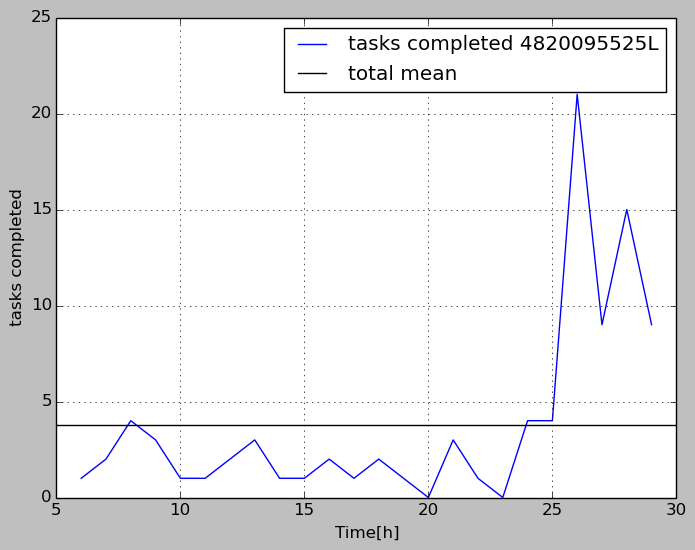

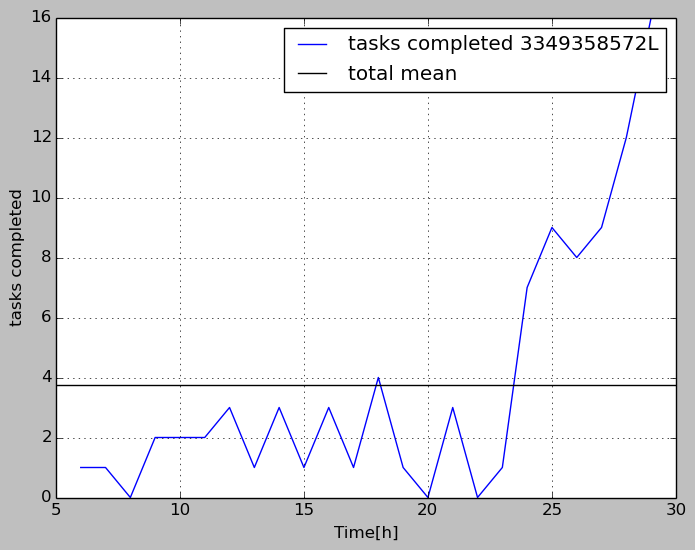

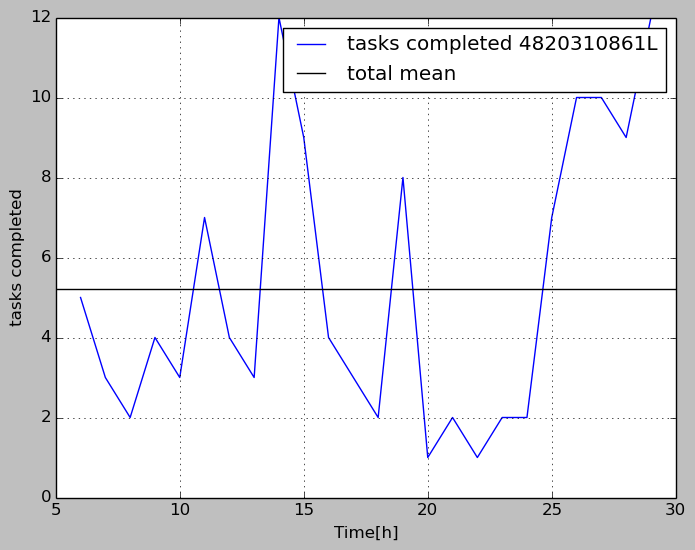

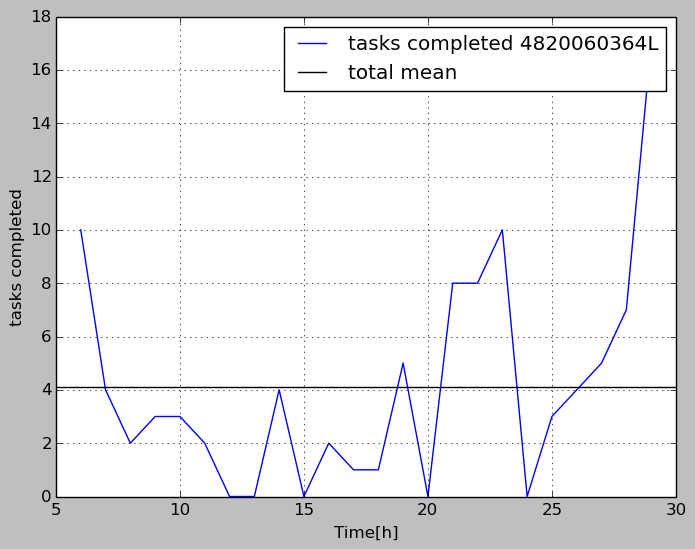

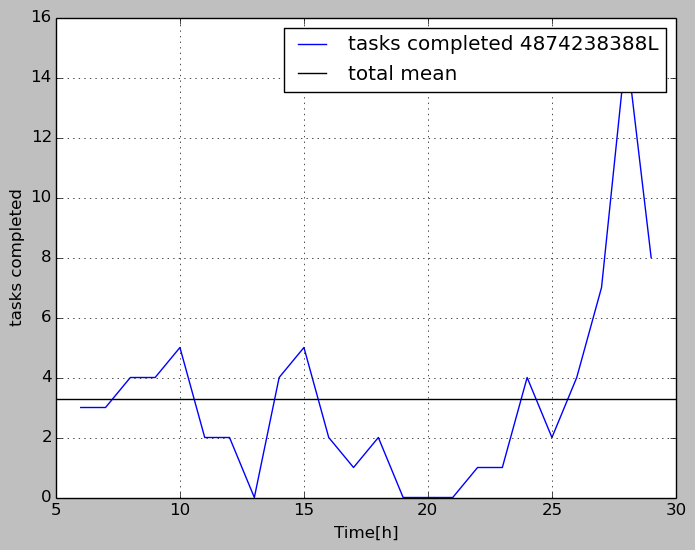

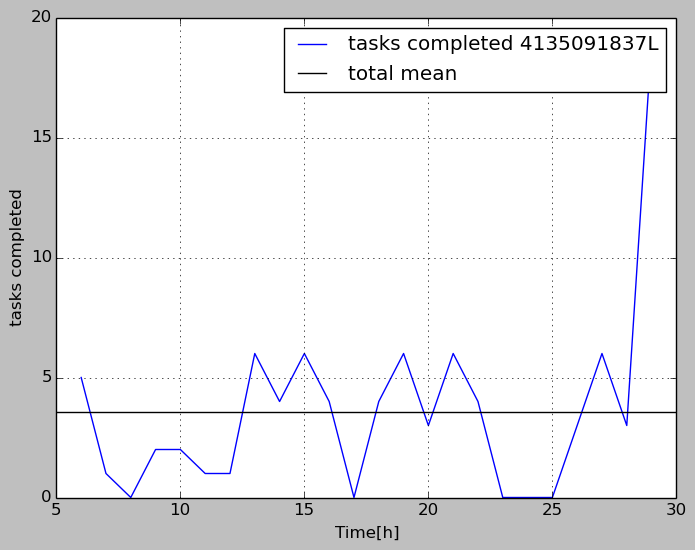

In [8]:
machines=[(4820211571L, 1455), (4820508012L, 1296), (4820235500L, 1286), (257407216, 1168), (4820095525L, 1138), (3349358572L, 1129), (4820310861L, 1112), (4820060364L, 1110), (4874238388L, 1103), (4135091837L, 1096)]
for m in machines:
    readMachineFiles('data/analysisResults/machines/5L-'+repr(m[0])+'event:4-3600.txt')

In [ ]:
def finishedTasksCount(startTimeMs,endTimeMs,granularityMs,data,records,machineID,event):
    previous=current=0
    #split by granularity and for each interval finds mean and variance
    while(startTimeMs<endTimeMs):
        #compute the sub-window
        e=startTimeMs+granularityMs
        #until we are in the interval
        while(records[current][0]<=e and current<(len(records)-1)):
            current+=1
        #appends the result to the list
        data.append(((startTimeMs,e),current-previous))
        #slide the window
        startTimeMs=e
        previous=current
    saveMachineResultCsv(data,machineID,event,granularityMs/1000000)
    drawMachine(event,data)
    
#compute the mean and variance number of tasks assigned to a specific machine
#take as input the path,startTime[s],endTime[s],granularity[s],machineID and event_type
#note that this function takes as input the path of the files, and everytime is called it parses the initial .csv data
#if you want to run a while loop and parse only one time, then you should use computeFinishTasks(...)
def computeMachineData(path,startTime,endTime,granularity,machine_id,event_type):
    if(startTime>endTime):
        print "Wrong window"
        return
    #converts to microseconds
    startTimeMs=startTime*1000000
    endTimeMs=endTime*1000000
    granularityMs=granularity*1000000
    data=[]
    #this contains all the trace in the format (timestamp [micros],jobID,event_type)
    googleRDD=(sc.textFile(path)
          .map(lambda x:x.split(','))
          #delete the empty machine (unknown assignment of the task)
          .filter(lambda x:x[4]!='')
           #map every tuple in: (timestamp [micros],machineID,event_type)
          .map(lambda x:(int(x[0]),int(x[4]),int(x[5])))
          .filter(lambda x:x[1]==machine_id)
          .filter(lambda x:x[2]==event_type)
          .filter(lambda x:x[0]>=startTimeMs and x[0]<=endTimeMs))
    #gets the list ordered by timestamp
    records=googleRDD.takeOrdered(googleRDD.count(),lambda x:x[0])
    finishedTasksCount(startTimeMs,endTimeMs,granularityMs,data,records,machine_id,event_type)
#take as input an array of machine ids and compute the data
def computeArrayOfMachine(path,startTime,endTime,granularity,machine_ids,event_type):
    if(startTime>endTime):
        print "Wrong window"
        return
    #converts to microseconds
    startTimeMs=startTime*1000000
    endTimeMs=endTime*1000000
    granularityMs=granularity*1000000
    data=[]
    #this contains all the trace in the format (timestamp [micros],jobID,event_type)
    googleRDD=(sc.textFile(path)
          .map(lambda x:x.split(','))
          #delete the empty machine (unknown assignment of the task)
          .filter(lambda x:x[4]!='')
           #map every tuple in: (timestamp [micros],machineID,event_type)
          .map(lambda x:(int(x[0]),int(x[4]),int(x[5])))
          .filter(lambda x:x[2]==event_type)
          .filter(lambda x:x[0]>=startTimeMs and x[0]<=endTimeMs))
    data=[]
    for machineID in machine_ids:
        records=googleRDD.filter(lambda x:x[1]==machineID).takeOrdered(googleRDD.count(),lambda x:x[0])
        finishedTasksCount(startTimeMs,endTimeMs,granularityMs,data,records,machineID,event_type)
        data=[]

machines=[1333836, 1094282, 8055081, 257504349, 7776858, 2110935011, 257348627, 3349888214L, 32055992, 317477951, 8055719, 854812624, 336030257,3349203058L, 351607179, 3349142245L, 6963258, 734367061, 2055351239, 16915992, 503714165, 1436486645, 1726343263, 1436302995, 2851473]
computeArrayOfMachine('file:///home/vagrant/data/googleTraces/*.csv.gz',18600,105000,3600/8,machines,4)

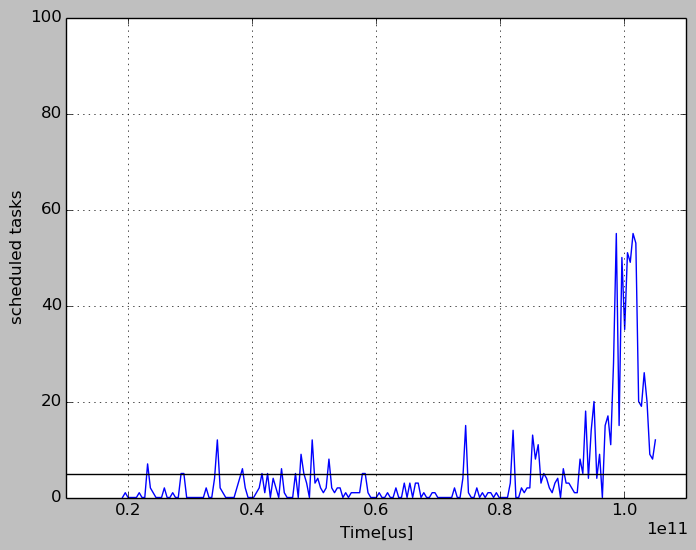

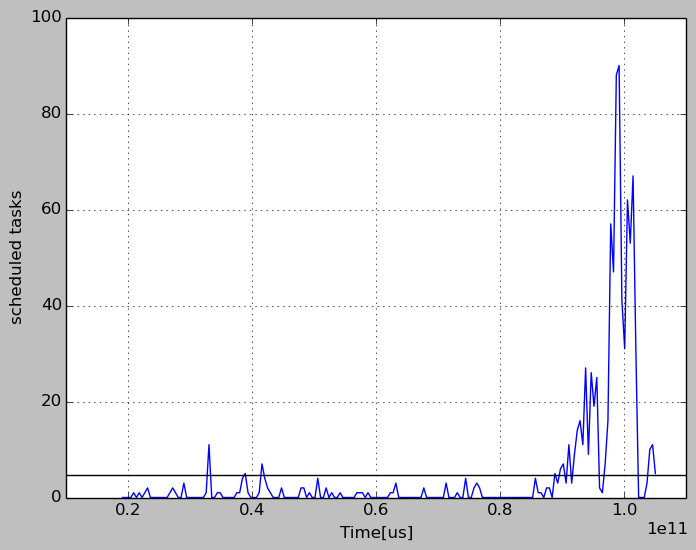

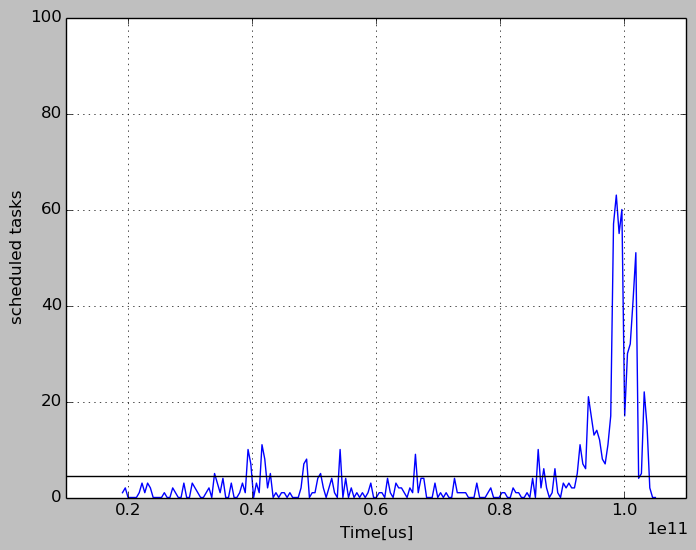

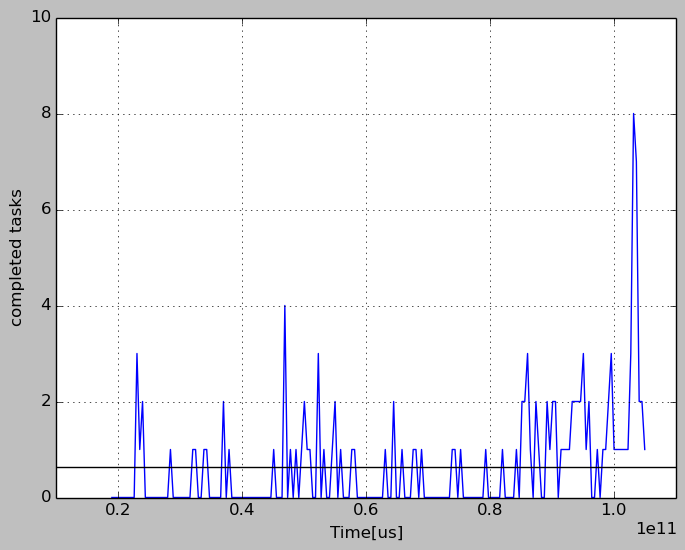

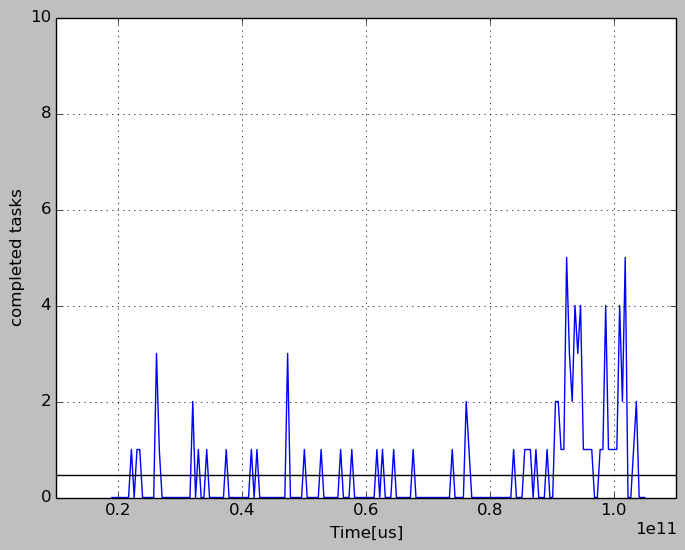

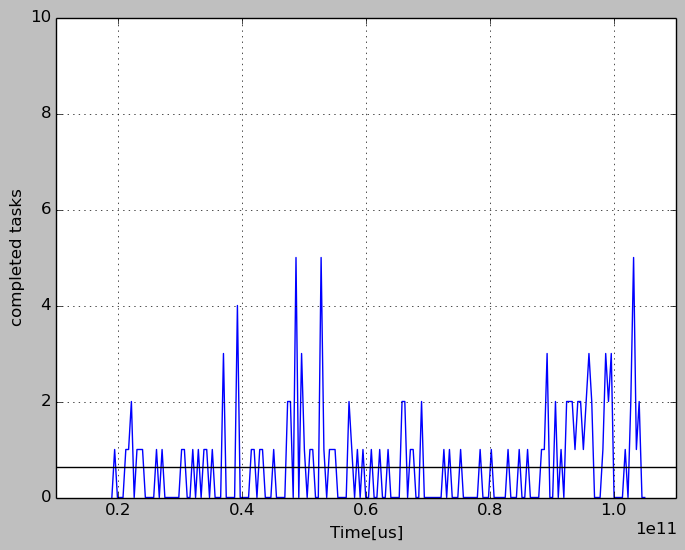

In [12]:
#grafici delle macchine analizzate (due punti per ora)
# 257407216. 4820095525L. 4820310861L.
readMachineFile('data/analysisResults/machines/5L-257407216event:1-450.csv',1)
readMachineFile('data/analysisResults/machines/5L-4820095525Levent:1-450.csv',1)
readMachineFile('data/analysisResults/machines/5L-4820310861Levent:1-450.csv',1)
readMachineFile('data/analysisResults/machines/5L-257407216event:4-450.csv',4)
readMachineFile('data/analysisResults/machines/5L-4820095525Levent:4-450.csv',4)
readMachineFile('data/analysisResults/machines/5L-4820310861Levent:4-450.csv',4)